In [1]:
#importing libraries
!pip install torch 
!pip install torchvision
!pip install imblearn
!pip install sklearn
import os
import random
from tqdm import tqdm
import numpy as np
import torch, torchvision
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset   

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

%matplotlib inline

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from numpy import vstack
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.optim import SGD
from torch.nn import BCELoss

In [2]:
# Read the Synthetic identity dataset in the dataframe
# data = pd.read_csv('drive/MyDrive/labeled_database.csv')
data = pd.read_csv('labeled_gen_database_2.csv')
data.head()

,Unnamed: 0,Name,DoB,Mobile,Email,Location,label
0,0,Misha Kumer,1972-04-18,9038740424,rohanhalder@hotmail.com,h no 19 agrawal circle hapur 968267\n,0
1,1,Jayesh Krishnan,1950-05-08,6646120647,sara93@gmail.com,h no 74 hora nagar bhilai 879957\n \n,0
2,2,Suhana Mall,1931-11-07,7249906782,hguha@hotmail.com,00 698 tata chowk bhusawal 537818\n,0
3,3,Drishya Mangat,2012-06-19,8095808991,fseth@gmail.com,816 dora coimbatore 986675\n,0
4,4,Rati Bahl,1971-03-20,6005627215,dsahni@gmail.com,49 shanker ganj pali 316971,0


0    50000
1     2500
Name: label, dtype: int64

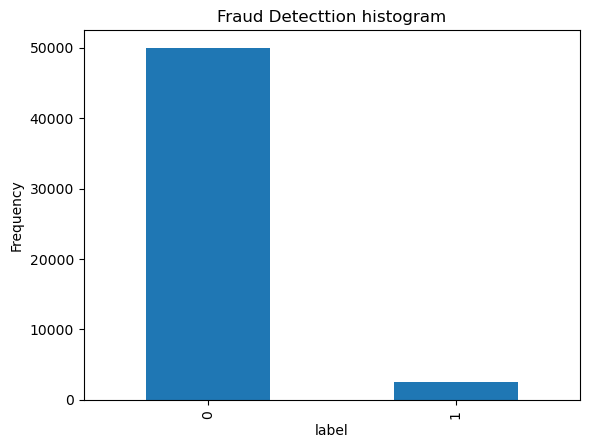

In [3]:
#print the lebels in the histogram to see frequecy
pd.value_counts(data['label']).plot.bar()
plt.title('Fraud Detecttion histogram')
plt.xlabel('label')
plt.ylabel('Frequency')
data['label'].value_counts()

In [4]:
import re
# Remove punctuation and apply case folding
def preprocessor(text):
    text = re.sub('<[^>]*>', '', str(text).lower())
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' .join(emoticons).replace('-', ''))

    return text

In [5]:
# apply the preprocessor to all columns

data['Name'] = data['Name'].apply(preprocessor)
data['DoB'] = data['DoB'].apply(preprocessor)
data['Mobile'] = data['Mobile'].apply(preprocessor)
data['Email'] = data['Email'].apply(preprocessor)
data['Location'] = data['Location'].apply(preprocessor)

data.head()

,Unnamed: 0,Name,DoB,Mobile,Email,Location,label
0,0,misha kumer,1972 04 18,9038740424,rohanhalder hotmail com,h no 19 agrawal circle hapur 968267,0
1,1,jayesh krishnan,1950 05 08,6646120647,sara93 gmail com,h no 74 hora nagar bhilai 879957,0
2,2,suhana mall,1931 11 07,7249906782,hguha hotmail com,00 698 tata chowk bhusawal 537818,0
3,3,drishya mangat,2012 06 19,8095808991,fseth gmail com,816 dora coimbatore 986675,0
4,4,rati bahl,1971 03 20,6005627215,dsahni gmail com,49 shanker ganj pali 316971,0


In [6]:
#to get the shape of the data
X = np.array(data.loc[:, data.columns != 'label'])
y = np.array(data.loc[:, data.columns == 'label'])
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))
X

Shape of X: (52500, 6)
Shape of y: (52500, 1)


array([[0, 'misha kumer', '1972 04 18', '9038740424',
        'rohanhalder hotmail com',
        'h no 19 agrawal circle hapur 968267 '],
       [1, 'jayesh krishnan', '1950 05 08', '6646120647',
        'sara93 gmail com', 'h no 74 hora nagar bhilai 879957 '],
       [2, 'suhana mall', '1931 11 07', '7249906782',
        'hguha hotmail com', '00 698 tata chowk bhusawal 537818 '],
       ...,
       [52497, 'nakul sane', '1947 01 07', '6439463054',
        'sahilranganathan hotmail com',
        '01 889 gopal street tadepalligudem 004421 '],
       [52498, 'riya khalsa', '2020 08 17', '7019102981',
        'ladarnav gmail com', '80 659 chhabra chowk kolhapur 921139 '],
       [52499, 'kabir kar', '1914 09 24', '7024039270',
        'dadauthkarsh yahoo com',
        'h no 87 tripathi nagar raebareli 678392 ']], dtype=object)

In [7]:
#feature selection
X_f = data['Name'] + ' ' + data['DoB'] + ' ' + data['Mobile'] + ' ' +  data['Email'] + ' ' + data['Location']
X_f

0        misha kumer 1972 04 18 9038740424 rohanhalder ...
1        jayesh krishnan 1950 05 08 6646120647 sara93 g...
2        suhana mall 1931 11 07 7249906782 hguha hotmai...
3        drishya mangat 2012 06 19 8095808991 fseth gma...
4        rati bahl 1971 03 20 6005627215 dsahni gmail c...
                               ...                        
52495    umang goda 1932 11 12 9279149821 borajayesh gm...
52496    zaina raja 1955 09 05 9803889919 upadhyayneelo...
52497    nakul sane 1947 01 07 6439463054 sahilranganat...
52498    riya khalsa 2020 08 17 7019102981 ladarnav gma...
52499    kabir kar 1914 09 24 7024039270 dadauthkarsh y...
Length: 52500, dtype: object

In [8]:
print(X_f.shape)

(52500,)


In [9]:
##vectorization of the selected features
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(use_idf=True, norm = 'l2', smooth_idf = True)

vectorized_df= tfidf_vectorizer.fit_transform(X_f)
print(vectorized_df.shape[1])
print(vectorized_df.dtype)
print(type(vectorized_df))

# Name 172255, 813

141144
float64
<class 'scipy.sparse._csr.csr_matrix'>


In [10]:
 from sklearn.decomposition import TruncatedSVD        
pca = TruncatedSVD(n_components=512)                                
X = pca.fit_transform(vectorized_df)

print(X.shape)
X

(52500, 512)


array([[ 0.12680982, -0.04819002, -0.04654459, ..., -0.00784358,
        -0.01882337,  0.00501895],
       [ 0.12812788, -0.01280948,  0.06418922, ...,  0.01144313,
        -0.01141852, -0.00642628],
       [ 0.09878401, -0.04857455, -0.037664  , ..., -0.00969315,
         0.01343787, -0.00701616],
       ...,
       [ 0.11386966, -0.06030723, -0.0343277 , ...,  0.00482551,
         0.01286171, -0.00938953],
       [ 0.09307892, -0.00600914,  0.06195946, ...,  0.02627246,
         0.01192399,  0.01654573],
       [ 0.12272073,  0.06814234, -0.02732279, ..., -0.00731894,
         0.00180339, -0.00774728]])

# Smote for oversampling

In [11]:
print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y==0)))

#to deal with the oversmapling smote is used
sm = SMOTE(random_state=2)
X_smote, y_smote = sm.fit_resample(X, y.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_smote.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_smote==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_smote==0)))

Before OverSampling, counts of label '1': [2500]
Before OverSampling, counts of label '0': [50000] 

After OverSampling, the shape of train_X: (100000, 512)
After OverSampling, the shape of train_y: (100000,) 

After OverSampling, counts of label '1': 50000
After OverSampling, counts of label '0': 50000


In [12]:
from sklearn.utils import shuffle

X_smote, y_smote = shuffle(X_smote, y_smote)
print(y_smote[0:1000])

[1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1
 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1
 0 0 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0
 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 1 1
 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1
 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1
 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1
 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1
 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1
 1 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0
 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0
 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1
 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1
 0 0 0 1 0 0 1 0 1 0 0 0 

In [13]:
#split the data in test and train in 20:80 ration and thier shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

print("Number of identities X_train dataset: ", X_train.shape)
print("Number of identities y_train dataset: ", y_train.shape)
print("Number of identities X_test dataset: ", X_test.shape)
print("Number of identities y_test dataset: ", y_test.shape)

Number of identities X_train dataset:  (42000, 512)
Number of identities y_train dataset:  (42000, 1)
Number of identities X_test dataset:  (10500, 512)
Number of identities y_test dataset:  (10500, 1)


In [14]:
#split the data in test and train in 20:80 ration and thier shape
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size = 0.30, random_state=0)

print("Number of identities X_train dataset: ", X_train_smote.shape)
print("Number of identities y_train dataset: ", y_train_smote.shape)
print("Number of identities X_test dataset: ", X_test_smote.shape)
print("Number of identities y_test dataset: ", y_test_smote.shape)

Number of identities X_train dataset:  (70000, 512)
Number of identities y_train dataset:  (70000,)
Number of identities X_test dataset:  (30000, 512)
Number of identities y_test dataset:  (30000,)


##  Logistic Regression with smote

In [15]:
print ('Train set:', X_train_smote.shape,  y_train_smote.shape)
print ('Test set:', X_test_smote.shape,  y_test_smote.shape)

Train set: (70000, 512) (70000,)
Test set: (30000, 512) (30000,)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
X_train_smote = np.nan_to_num(X_train_smote)
y_train_smote = np.nan_to_num(y_train_smote)
smote_model = LogisticRegression().fit(X_train_smote, y_train_smote)
smote_model

LogisticRegression()

In [17]:
X_test_smote = np.nan_to_num(X_test_smote)
yhat_smote = smote_model.predict(X_test_smote)
yhat_smote

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [18]:
yhat_smote_prob = smote_model.predict_proba(X_test_smote)
yhat_smote_prob

array([[0.26540308, 0.73459692],
       [0.40422798, 0.59577202],
       [0.27812956, 0.72187044],
       ...,
       [0.8791504 , 0.1208496 ],
       [0.52825773, 0.47174227],
       [0.96073159, 0.03926841]])

In [19]:
# Accuracy Score

acc_score_smote = smote_model.score(X_test_smote, y_test_smote)
acc_score_smote

0.6277333333333334

In [20]:
# Confusion Matrix

from sklearn import metrics
conf_matrix_smote = metrics.confusion_matrix(y_test_smote, yhat_smote)
classfic_rep_smote = metrics.classification_report(y_test_smote, yhat_smote)
print(classfic_rep_smote)
conf_matrix_smote

              precision    recall  f1-score   support

           0       0.63      0.59      0.61     14995
           1       0.62      0.65      0.63     15005

    accuracy                           0.62     30000
   macro avg       0.62      0.62      0.62     30000
weighted avg       0.62      0.62      0.62     30000



array([[8904, 6091],
       [5194, 9811]], dtype=int64)

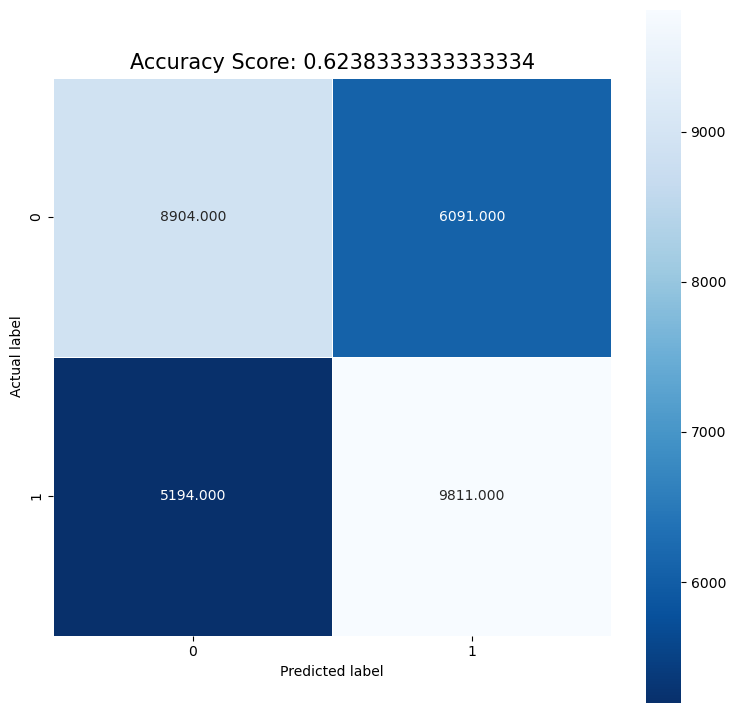

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix_smote, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_score_smote)
plt.title(all_sample_title, size = 15);

## Logistic Regression without smote

In [22]:
y_train = y_train.ravel()
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (42000, 512) (42000,)
Test set: (10500, 512) (10500, 1)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
model = LogisticRegression().fit(X_train, y_train)
model

LogisticRegression()

In [24]:
X_test = np.nan_to_num(X_test)
yhat = model.predict(X_test)
yhat

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [25]:
yhat_prob = model.predict_proba(X_test)
yhat_prob

array([[0.94666318, 0.05333682],
       [0.96115246, 0.03884754],
       [0.96295016, 0.03704984],
       ...,
       [0.95349994, 0.04650006],
       [0.95519079, 0.04480921],
       [0.95814422, 0.04185578]])

In [26]:
#Accuracy Score

acc_score = model.score(X_test, y_test)
acc_score

0.9524761904761905

In [27]:
# Confusion Matrix

from sklearn import metrics
conf_matrix = metrics.confusion_matrix(y_test, yhat)
classfic_rep = metrics.classification_report(y_test, yhat)
print(classfic_rep)
conf_matrix

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     10001
           1       0.00      0.00      0.00       499

    accuracy                           0.95     10500
   macro avg       0.48      0.50      0.49     10500
weighted avg       0.91      0.95      0.93     10500



C:\Users\sures\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sures\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sures\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[10001,     0],
       [  499,     0]], dtype=int64)

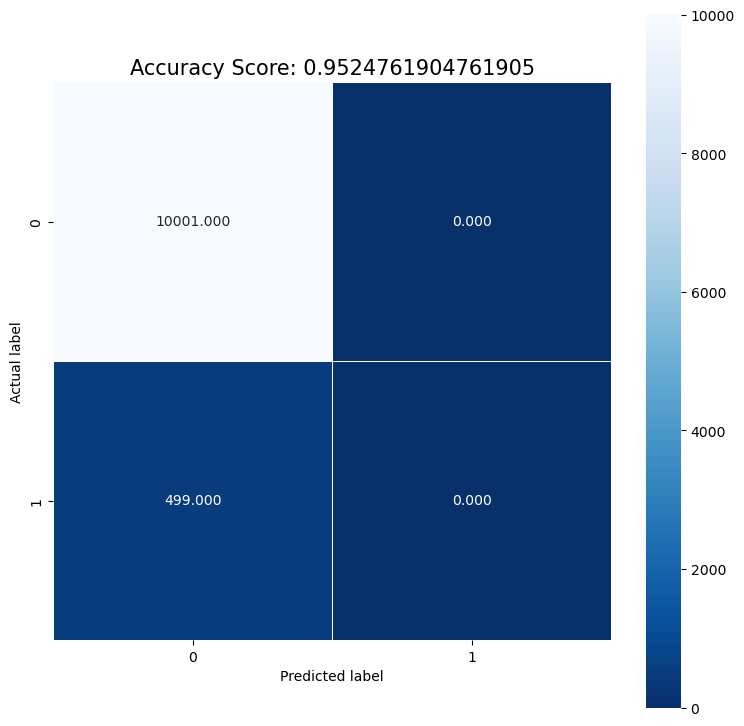

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 15);

## Random forest with smote

In [20]:
print ('Train set:', X_train_smote.shape,  y_train_smote.shape)
print ('Test set:', X_test_smote.shape,  y_test_smote.shape)

Train set: (70000, 512) (70000,)
Test set: (30000, 512) (30000,)


ACCURACY OF THE MODEL:  0.9663
Recall OF THE MODEL:  0.9663
F1 Score OF THE MODEL:  0.9658941402692035
Confusion matrix:  [[14673   286]
 [  725 14316]]
Classification report:                precision    recall  f1-score   support

           0       0.95      0.98      0.97     14959
           1       0.98      0.95      0.97     15041

    accuracy                           0.97     30000
   macro avg       0.97      0.97      0.97     30000
weighted avg       0.97      0.97      0.97     30000



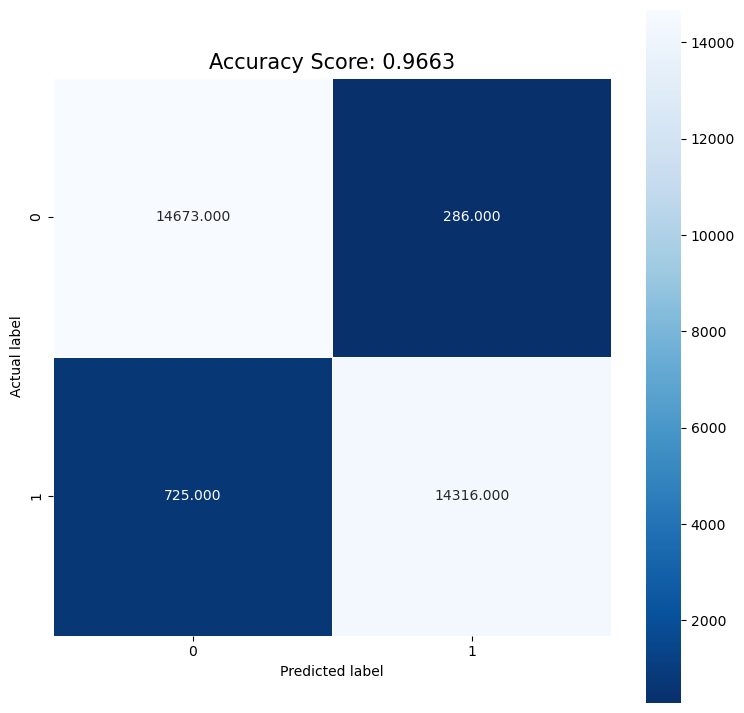

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf_smote = RandomForestClassifier(n_estimators = 10)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf_smote.fit(X_train_smote, y_train_smote)
  
# performing predictions on the test dataset
y_pred_smote = clf_smote.predict(X_test_smote)
  
# using metrics module for accuracy calculation
acc_rand_smote = metrics.accuracy_score(y_test_smote, y_pred_smote)
print("ACCURACY OF THE MODEL: ", acc_rand_smote)

rec_rand_smote = metrics.recall_score(y_test_smote, y_pred_smote)
print("Recall OF THE MODEL: ", acc_rand_smote)

f1_rand_smote = metrics.f1_score(y_test_smote, y_pred_smote)
print("F1 Score OF THE MODEL: ", f1_rand_smote)

# using metrics module for confusion matrix
conf_rand_smote = metrics.confusion_matrix(y_test_smote, y_pred_smote)
                                           
print("Confusion matrix: ", conf_rand_smote)

# using metrics module for classification report
class_rand_smote = metrics.classification_report(y_test_smote, y_pred_smote)
print("Classification report: ", class_rand_smote)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(conf_rand_smote, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_rand_smote)
plt.title(all_sample_title, size = 15);

## Random Forest without smote

In [31]:
y_train = y_train.ravel()
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (42000, 512) (42000,)
Test set: (10500, 512) (10500, 1)


ACCURACY OF THE MODEL:  0.9521904761904761
Confusion matrix:  [[9998    3]
 [ 499    0]]
Classification report:                precision    recall  f1-score   support

           0       0.95      1.00      0.98     10001
           1       0.00      0.00      0.00       499

    accuracy                           0.95     10500
   macro avg       0.48      0.50      0.49     10500
weighted avg       0.91      0.95      0.93     10500



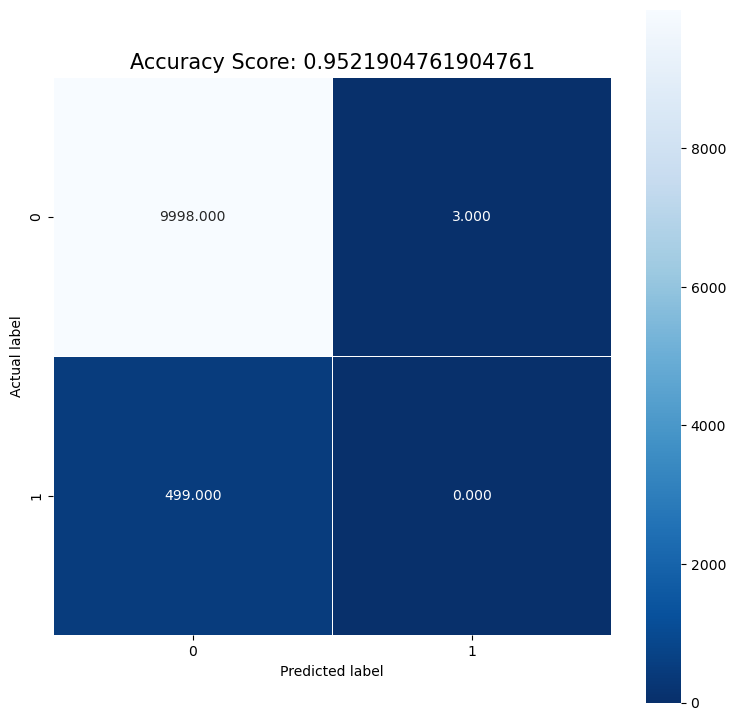

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf = RandomForestClassifier(n_estimators = 10)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
  
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
  
# using metrics module for accuracy calculation
acc_rand = metrics.accuracy_score(y_test, y_pred)
print("ACCURACY OF THE MODEL: ", acc_rand)

# using metrics module for confusion matrix
conf_rand = metrics.confusion_matrix(y_test, y_pred)
print("Confusion matrix: ", conf_rand)

# using metrics module for classification report
class_rand = metrics.classification_report(y_test, y_pred)
print("Classification report: ", class_rand)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(conf_rand, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_rand)
plt.title(all_sample_title, size = 15);

## KNN with Smote

In [33]:
print ('Train set:', X_train_smote.shape,  y_train_smote.shape)
print ('Test set:', X_test_smote.shape,  y_test_smote.shape)

Train set: (70000, 512) (70000,)
Test set: (30000, 512) (30000,)


C:\Users\sures\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


ACCURACY OF THE MODEL:  0.5448666666666667
Confusion matrix:  [[ 1341 13654]
 [    0 15005]]
Classification report:                precision    recall  f1-score   support

           0       1.00      0.09      0.16     14995
           1       0.52      1.00      0.69     15005

    accuracy                           0.54     30000
   macro avg       0.76      0.54      0.43     30000
weighted avg       0.76      0.54      0.43     30000



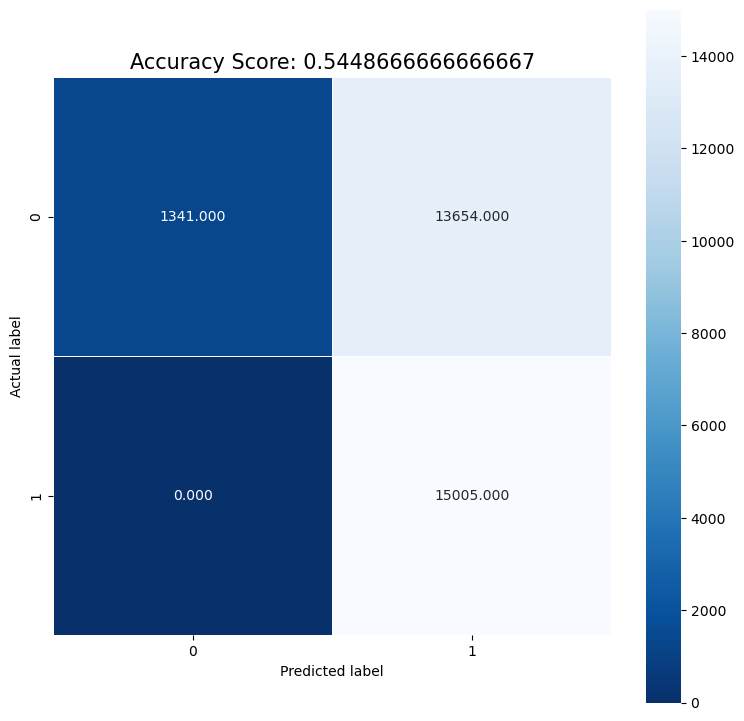

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_smote)

X_train = scaler.transform(X_train_smote)
X_test = scaler.transform(X_test_smote)


from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
classifier.fit(X_train_smote, y_train_smote)


y_pred_smote = classifier.predict(X_test_smote)

# using metrics module for accuracy calculation
acc_knn_smote = metrics.accuracy_score(y_test_smote, y_pred_smote)
print("ACCURACY OF THE MODEL: ", acc_knn_smote)

# using metrics module for confusion matrix
conf_knn_smote = metrics.confusion_matrix(y_test_smote, y_pred_smote)                                       
print("Confusion matrix: ", conf_knn_smote)

# using metrics module for classification report
class_knn_smote = metrics.classification_report(y_test_smote, y_pred_smote)
print("Classification report: ", class_knn_smote)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(conf_knn_smote, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_knn_smote)
plt.title(all_sample_title, size = 15);

C:\Users\sures\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\sures\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


ACCURACY OF THE MODEL:  0.9522857142857143
Confusion matrix:  [[9999    2]
 [ 499    0]]
Classification report:                precision    recall  f1-score   support

           0       0.95      1.00      0.98     10001
           1       0.00      0.00      0.00       499

    accuracy                           0.95     10500
   macro avg       0.48      0.50      0.49     10500
weighted avg       0.91      0.95      0.93     10500



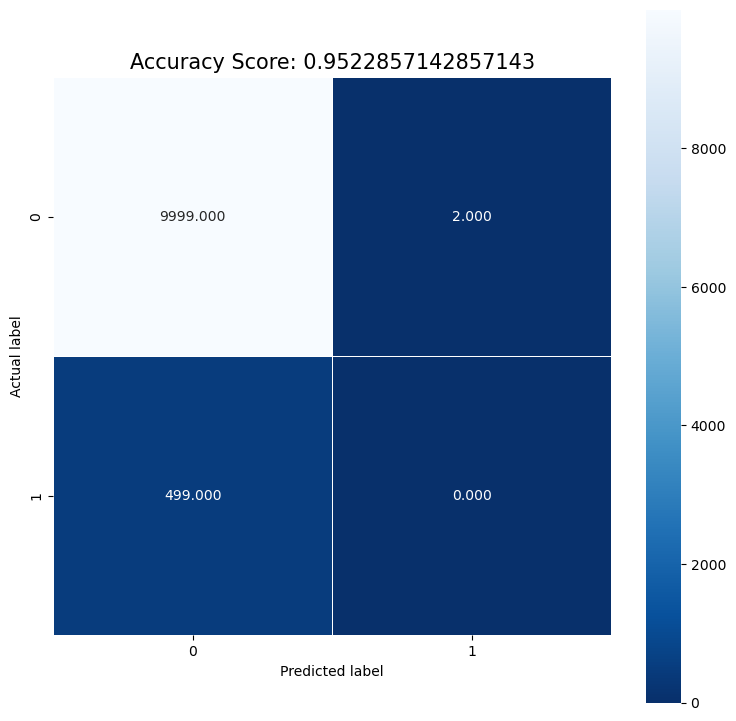

In [16]:
# KNN wihout smote

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_test)

# using metrics module for accuracy calculation
acc_knn = metrics.accuracy_score(y_test, y_pred)
print("ACCURACY OF THE MODEL: ", acc_knn)

# using metrics module for confusion matrix
conf_knn = metrics.confusion_matrix(y_test, y_pred)                                       
print("Confusion matrix: ", conf_knn)

# using metrics module for classification report
class_knn = metrics.classification_report(y_test, y_pred)
print("Classification report: ", class_knn)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(conf_knn, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_knn)
plt.title(all_sample_title, size = 15);

# Neural Network

In [30]:

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Dropout

earlystopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0.01,
                              patience = 50,
                              verbose = 1,
                              baseline = 2,
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('test.h8',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
    

model = Sequential()
model.add(Dense(70, input_dim=512, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train_smote, y_train_smote, batch_size = 32, epochs=10, validation_data=(X_test_smote, y_test_smote), callbacks = [earlystopping], shuffle=True)


Epoch 1/10
2188/2188 [==============================] - 38s 12ms/step - loss: 0.3256 - accuracy: 0.8481 - val_loss: 0.1355 - val_accuracy: 0.9497
Epoch 2/10
2188/2188 [==============================] - 24s 11ms/step - loss: 0.0788 - accuracy: 0.9718 - val_loss: 0.0945 - val_accuracy: 0.9648
Epoch 3/10
2188/2188 [==============================] - 22s 10ms/step - loss: 0.0453 - accuracy: 0.9835 - val_loss: 0.0889 - val_accuracy: 0.9672
Epoch 4/10
2188/2188 [==============================] - 22s 10ms/step - loss: 0.0330 - accuracy: 0.9883 - val_loss: 0.0891 - val_accuracy: 0.9698
Epoch 5/10
2188/2188 [==============================] - 23s 11ms/step - loss: 0.0285 - accuracy: 0.9898 - val_loss: 0.0906 - val_accuracy: 0.9697
Epoch 6/10
2188/2188 [==============================] - 22s 10ms/step - loss: 0.0224 - accuracy: 0.9918 - val_loss: 0.0806 - val_accuracy: 0.9745
Epoch 7/10
2188/2188 [==============================] - 24s 11ms/step - loss: 0.0208 - accuracy: 0.9928 - val_loss: 0.0789 -

In [ ]:
yhat_probs = model.predict(X_test_smote, verbose=0)
# predict crisp classes for test set
y_pred = tf.where(yhat_probs<=0.5,0,1)
accuracy = accuracy_score(y_test_smote, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_smote, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_smote, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_smote, y_pred)
print('F1 score: %f' % f1)